<a href="https://colab.research.google.com/github/Sogo95/Detection-de-tweet/blob/main/process_v_sogo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**INTRODUCTION**


In [ ]:
#Importation des librairie nécéssaires
!pip install scikit-learn==1.0.2 # Install scikit-learn version 1.0.2 where plot_roc_curve is still available
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 57.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.25.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.
mlxtend 0.23.2 requires scikit-learn>=1.3.1, but you have scikit-learn 1.0.2 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/tweets_suspect.csv')


#**Exploration de notre Dataset**
Avant de procéder à la construction du modèle faisons d'abord une exploration de notre dataset afin d'avoir de bons insights et de mieux préparer les données

In [ ]:
# Affichons les premières lignes et les informations générales
print(df.head())


                                             message  label
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...      1
1  is upset that he can't update his Facebook by ...      1
2  @Kenichan I dived many times for the ball. Man...      1
3    my whole body feels itchy and like its on fire       0
4  @nationwideclass no, it's not behaving at all....      1


In [ ]:
# Affichons les informations numéraires de notre jeu de données
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  60000 non-null  object
 1   label    60000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 937.6+ KB
None


In [ ]:
# Faisons une description statistique de notre jeu de données
print(df.describe())

              label
count  60000.000000
mean       0.897583
std        0.303198
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000


In [ ]:
# Calcul de la distribution des classes
print(df['label'].value_counts(normalize=True))

label
1    0.897583
0    0.102417
Name: proportion, dtype: float64


Nous remarqu'on a un grand déséquilibre entre les deux classes

*   Environ 89% des tweets sont jugés suspects
*   Environ 10% des tweets sont jugés non suspects

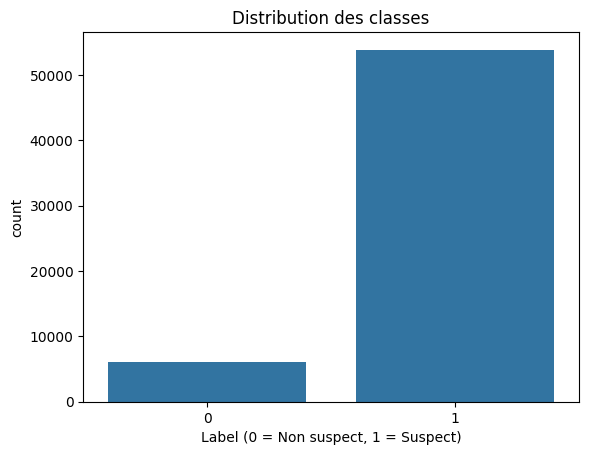

In [ ]:
# Visualisons cette distribution avec un graphique
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='label')
plt.title("Distribution des classes")
plt.xlabel("Label (0 = Non suspect, 1 = Suspect)")
plt.show()

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


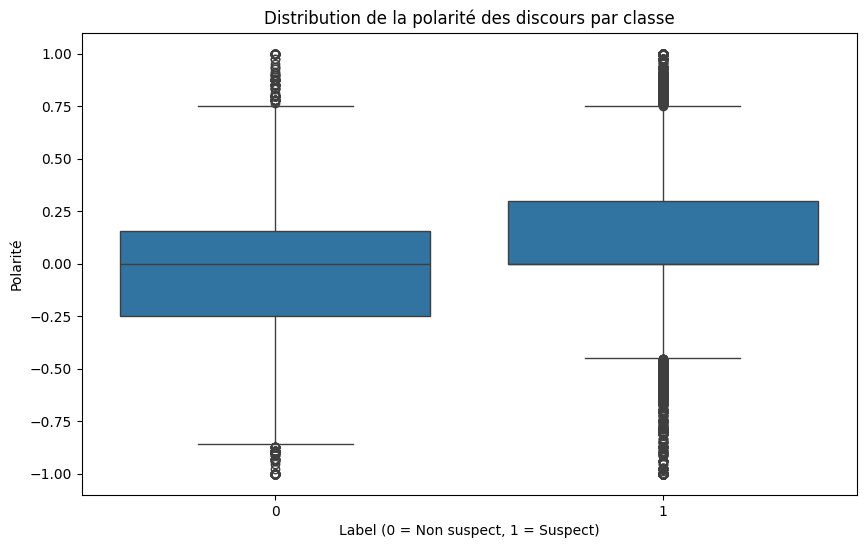

In [ ]:
# Analyse de la polarité et des sentiments
!pip install textblob
!python -m textblob.download_corpora

from textblob import TextBlob

# Fonction pour calculer la polarité
df['polarity'] = df['message'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Visualisation de la polarité par classe
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='label', y='polarity')
plt.title("Distribution de la polarité des discours par classe")
plt.xlabel("Label (0 = Non suspect, 1 = Suspect)")
plt.ylabel("Polarité")
plt.show()


Le graphique ci-dessus montre la distribution de la polarité des discours pour deux classes : non suspect (0) et suspect (1). Les discours non suspects ont une polarité centrée autour de zéro, reflétant une tonalité plutôt neutre. Les discours suspects, bien que similaires, présentent une plus grande variabilité avec une légère tendance vers des polarités plus négatives. Les outliers indiquent des discours très positifs ou négatifs dans chaque catégorie. Globalement, la polarité seule montre des différences limitées entre les deux classes

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Identification des bigrammes
vectorizer = CountVectorizer(ngram_range=(2, 3), max_features=20, stop_words='english')
X_ngrams = vectorizer.fit_transform(df['message'])
ngrams = vectorizer.get_feature_names_out()

# Visualiser les bigrammes les plus fréquents
print("Bigrams et trigrams fréquents :\n", ngrams)


Bigrams et trigrams fréquents :
 ['bit ly' 'don know' 'don want' 'feel like' 'getting ready' 'going bed'
 'good morning' 'good night' 'http bit' 'http bit ly' 'http tinyurl'
 'http tinyurl com' 'http twitpic' 'http twitpic com' 'http www'
 'just got' 'looking forward' 'looks like' 'tinyurl com' 'twitpic com']


#**PREPARATION DES DONNEES**

##**Étape 1 : Nettoyage du texte**

Le nettoyage des données textuelles est important pour éliminer les éléments inutiles et normaliser le texte.

In [ ]:
# Suppression des caractères spéciaux, des URLs, des nombres et des ponctuations
import re

def clean_text(text):
    # Supprimer les URLs , des balises HTML
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'<.*?>', '', text)

    # Supprimer les caractères spéciaux et ponctuations
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    # Supprimer les nombres
    text = re.sub(r'\d+', '', text)
    # Convertir en minuscule
    text = text.lower()
    return text

# Appliquer la fonction de nettoyage à chaque texte
df['message'] = df['message'].apply(clean_text)
print(df['message'].head())


0    switchfoot a thats a bummer you shoulda got da...
1    is upset that he cant update his facebook by t...
2    kenichan i dived many times for the ball manag...
3      my whole body feels itchy and like its on fire 
4    nationwideclass no its not behaving at all im ...
Name: message, dtype: object


In [ ]:
# Suppression des mots vides (stop words)
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])

df['message'] = df['message'].apply(remove_stopwords)
print(df['message'].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0    switchfoot thats bummer shoulda got david carr...
1    upset cant update facebook texting might cry r...
2    kenichan dived many times ball managed save re...
3                     whole body feels itchy like fire
4             nationwideclass behaving im mad cant see
Name: message, dtype: object


##**Étape 2 : Normalisation des mots avec lemmatisation**

In [ ]:
from nltk.stem import WordNetLemmatizer
# Download 'punkt_tab' and 'wordnet' data packages
nltk.download('punkt_tab')  # Download for sentence tokenization
nltk.download('wordnet')  # Download for lemmatization

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
      tokens = nltk.word_tokenize(text)
      lemmatized = [lemmatizer.lemmatize(token.lower()) for token in tokens]
      return ' '.join(lemmatized)

df['message'] = df['message'].apply(lemmatize_text)
print(df['message'].head())



[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    switchfoot thats bummer shoulda got david carr...
1    upset cant update facebook texting might cry r...
2    kenichan dived many time ball managed save res...
3                      whole body feel itchy like fire
4             nationwideclass behaving im mad cant see
Name: message, dtype: object


##**Étape 3 : Analyse des n-grammes**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Convert stop_words to a list
stop_words_list = list(stop_words)

vectorizer = CountVectorizer(ngram_range=(2, 3), max_features=20, stop_words=stop_words_list) # Pass the list here
X_ngrams = vectorizer.fit_transform(df['message'])

# Visualiser les bigrams/trigrams les plus fréquents
print("Bigrams et trigrams fréquents :\n", vectorizer.get_feature_names_out())

Bigrams et trigrams fréquents :
 ['cant wait' 'dont know' 'dont want' 'feel like' 'getting ready' 'go back'
 'gon na' 'good morning' 'good night' 'got ta' 'im going' 'im sorry'
 'last day' 'last night' 'look like' 'looking forward' 'na go' 'wan na'
 'want go' 'wish could']


#**Étape 4 : Embeddings: Vectorisation avec BERT**

Ici, nous allons utilisé le mondèle de DistilBERT qui est un modèle dérivé de BERT, pour faire les représentations vectorielles des tweets. Nous utilisons ici DistilBERT car nous n'avons pas de ressources machine.

In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch

model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertModel.from_pretrained(model_name)

def encode_tweet(tweet):
    inputs = tokenizer(tweet, return_tensors='pt', padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return cls_embedding

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# Application de la fonction d'encodage sur la colonne 'message'
df['embedding'] = df['message'].apply(encode_tweet)

print("Embeddings générés.")
print(df['embedding'].head())

##**Étape 5 : Traitement des classes déséquilibrées**

Si les classes sont déséquilibrées, cela peut affecter les performances du modèle.

In [ ]:
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
X=df['embedding'].to_list()
y = df['label']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X,y)

print("Distribution des classes après sur-échantillonnage :", pd.Series(y_resampled).value_counts())


Distribution des classes après sur-échantillonnage : label
1    53855
0    53855
Name: count, dtype: int64


##**Étape 6 : Division des données en ensemble d'entraînement et de test**

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(np.array(X_resampled), y_resampled, test_size=0.2, random_state=42)

print("Dimensions de l'ensemble d'entraînement :", X_train.shape)
print("Dimensions de l'ensemble de test :", X_test.shape)


Dimensions de l'ensemble d'entraînement : (86168, 768)
Dimensions de l'ensemble de test : (21542, 768)


#**Entraînement des différents modèles de classification**

##**Régression Logistique**

In [ ]:
f1_scores = {}
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score

# Créer un pipeline pour la normalisation
log_reg_pipeline = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(max_iter=1000, class_weight='balanced'))

# Entraîner le modèle
log_reg_pipeline.fit(X_train, y_train)

# Évaluation
y_pred_log_reg = log_reg_pipeline.predict(X_test)

f1_log_reg = f1_score(y_test, y_pred_log_reg, average='weighted')
f1_scores['Logistic Regression'] = f1_log_reg

from sklearn.metrics import classification_report, accuracy_score
print("Régression Logistique avec Normalisation - Rapport de classification :\n", classification_report(y_test, y_pred_log_reg))
print("Régression Logistique avec Normalisation - Précision : ", accuracy_score(y_test, y_pred_log_reg))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Régression Logistique avec Normalisation - Rapport de classification :
               precision    recall  f1-score   support

           0       0.79      0.81      0.80     10709
           1       0.81      0.79      0.80     10833

    accuracy                           0.80     21542
   macro avg       0.80      0.80      0.80     21542
weighted avg       0.80      0.80      0.80     21542

Régression Logistique avec Normalisation - Précision :  0.7997400427072695


##**Support Vector Machine (SVM)**

In [ ]:
from sklearn.svm import SVC

# Entraîner le modèle SVM
svm_model = SVC(class_weight='balanced')
svm_model.fit(X_train, y_train)

# Prédictions et évaluation
y_pred_svm = svm_model.predict(X_test)

f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
f1_scores['SVM'] = f1_svm

print("SVM - Rapport de classification :\n", classification_report(y_test, y_pred_svm))
print("SVM - Précision : ", accuracy_score(y_test, y_pred_svm))


SVM - Rapport de classification :
               precision    recall  f1-score   support

           0       0.86      0.85      0.86     10709
           1       0.86      0.87      0.86     10833

    accuracy                           0.86     21542
   macro avg       0.86      0.86      0.86     21542
weighted avg       0.86      0.86      0.86     21542

SVM - Précision :  0.8607371646086714


##**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Entraîner le modèle Random Forest
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# Prédictions et évaluation
y_pred_rf = rf_model.predict(X_test)

f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
f1_scores['Random Forest'] = f1_rf

print("Random Forest - Rapport de classification :\n", classification_report(y_test, y_pred_rf))
print("Random Forest - Précision : ", accuracy_score(y_test, y_pred_rf))


Random Forest - Rapport de classification :
               precision    recall  f1-score   support

           0       0.95      0.97      0.96     10709
           1       0.97      0.95      0.96     10833

    accuracy                           0.96     21542
   macro avg       0.96      0.96      0.96     21542
weighted avg       0.96      0.96      0.96     21542

Random Forest - Précision :  0.9578962027666883


##**Arbre de Décision**



In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Entraîner l'arbre de décision avec une profondeur maximale pour limiter le surapprentissage
decision_tree = DecisionTreeClassifier(max_depth=10, class_weight='balanced', random_state=42)
decision_tree.fit(X_train, y_train)

# Prédictions et évaluation
y_pred_tree = decision_tree.predict(X_test)

f1_tree = f1_score(y_test, y_pred_tree, average='weighted')
f1_scores['Decision Tree'] = f1_tree

print("Arbre de Décision - Rapport de classification :\n", classification_report(y_test, y_pred_tree))
print("Arbre de Décision - Précision : ", accuracy_score(y_test, y_pred_tree))


Arbre de Décision - Rapport de classification :
               precision    recall  f1-score   support

           0       0.69      0.85      0.76     10709
           1       0.81      0.61      0.70     10833

    accuracy                           0.73     21542
   macro avg       0.75      0.73      0.73     21542
weighted avg       0.75      0.73      0.73     21542

Arbre de Décision - Précision :  0.7314084114752576


##**K-Nearest Neighbors (KNN)**



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Créer un pipeline avec normalisation et KNN
knn_pipeline = make_pipeline(StandardScaler(with_mean=False), KNeighborsClassifier(n_neighbors=5))

# Entraîner le modèle KNN
knn_pipeline.fit(X_train, y_train)

# Prédictions et évaluation
y_pred_knn = knn_pipeline.predict(X_test)

f1_knn = f1_score(y_test, y_pred_knn, average='weighted')
f1_scores['KNN'] = f1_knn

print("KNN - Rapport de classification :\n", classification_report(y_test, y_pred_knn))
print("KNN - Précision : ", accuracy_score(y_test, y_pred_knn))

KNN - Rapport de classification :
               precision    recall  f1-score   support

           0       0.72      0.97      0.83     10709
           1       0.96      0.62      0.75     10833

    accuracy                           0.80     21542
   macro avg       0.84      0.80      0.79     21542
weighted avg       0.84      0.80      0.79     21542

KNN - Précision :  0.796119208987095


##**XGBoost**



In [ ]:
!pip install xgboost
from xgboost import XGBClassifier

# Entraîner le modèle XGBoost avec un équilibrage des classes
xgb_model = XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Prédictions et évaluation
y_pred_xgb = xgb_model.predict(X_test)

f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')
f1_scores['XGBoost'] = f1_xgb

print("XGBoost - Rapport de classification :\n", classification_report(y_test, y_pred_xgb))
print("XGBoost - Précision : ", accuracy_score(y_test, y_pred_xgb))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:20:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.87      0.92     10709
           1       0.88      0.99      0.93     10833

    accuracy                           0.93     21542
   macro avg       0.94      0.93      0.93     21542
weighted avg       0.94      0.93      0.93     21542

XGBoost - Précision :  0.9297186890725095


#**Comparaison de nos modèles**

# #**Evalutaion du modèle SVM**



In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(f1_scores.keys(), f1_scores.values(), color=['blue', 'orange', 'green', 'red', 'purple'])
plt.xlabel('Modèles')
plt.ylabel('F1-Score')
plt.title('Comparaison des F1-Scores pour chaque Modèle')
plt.ylim(0, 1)  # Limiter l'axe y entre 0 et 1
plt.xticks(rotation=45)
plt.show()

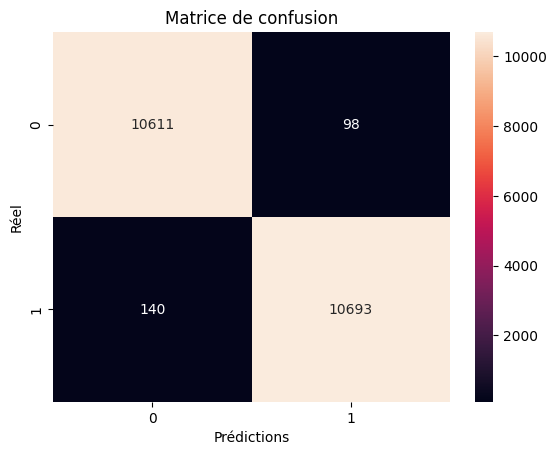

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


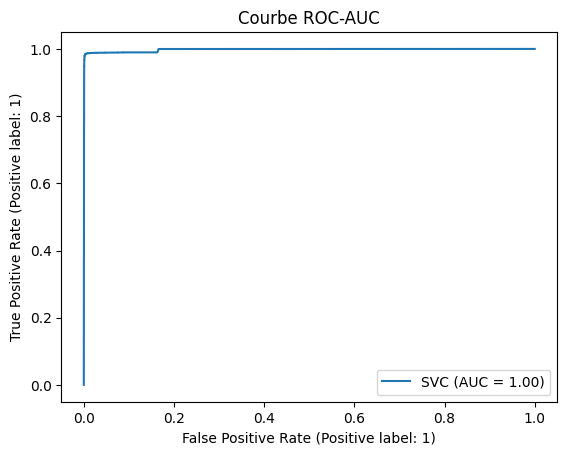

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, plot_roc_curve
import matplotlib.pyplot as plt

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.show()

# Courbe ROC-AUC
plot_roc_curve(svm_model, X_test, y_test)
plt.title("Courbe ROC-AUC")
plt.show()


# **Amélioration du modèle SVM**



## **Ajuster les Hyperparamètres avec Grid Search**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
import scipy.stats as stats

from sklearn.model_selection import train_test_split

# Utiliser une sous-partie de l'ensemble d'entraînement (par exemple, 30 %)
X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, train_size=0.3, random_state=42)


# Configurer la Randomized Search avec une distribution de paramètres
param_dist = {
    'C': stats.uniform(0.1, 100),    # Distribution continue pour C
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': stats.uniform(0.001, 1) # Distribution continue pour gamma
}

# Randomized Search avec 10 combinaisons et validation croisée
random_search = RandomizedSearchCV(SVC(class_weight='balanced'), param_distributions=param_dist, n_iter=10, cv=3, scoring='f1', random_state=42)

# Entraîner la Randomized Search
random_search.fit(X_train, y_train)

# Meilleures hyperparamètres
print("Meilleurs hyperparamètres SVM (Randomized Search) :", random_search.best_params_)
best_svm_model = random_search.best_estimator_


In [ ]:
from sklearn.model_selection import GridSearchCV

# Définir la grille de paramètres
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.001, 0.01, 0.1, 1]
}

# Configurer la Grid Search avec validation croisée
grid_search = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=5, scoring='f1')

# Entraîner la recherche
grid_search.fit(X_train, y_train)

# Meilleures hyperparamètres
print("Meilleures hyperparamètres SVM :", grid_search.best_params_)
best_svm_model = grid_search.best_estimator_


## **Essayer un Search Space plus Fin**

In [ ]:
# Affiner la grille de recherche
fine_param_grid = {
    'C': [5, 10, 15],
    'kernel': ['rbf'],
    'gamma': [0.005, 0.01, 0.05]
}

fine_grid_search = GridSearchCV(SVC(class_weight='balanced'), fine_param_grid, cv=5, scoring='f1')
fine_grid_search.fit(X_train, y_train)
print("Meilleures hyperparamètres après ajustement fin :", fine_grid_search.best_params_)

## **Utiliser une Validation Croisée plus Grande pour Affiner la Sélection**

In [ ]:
# Refaire la Grid Search avec une validation croisée à 10 segments
grid_search_10fold = GridSearchCV(SVC(class_weight='balanced'), fine_param_grid, cv=10, scoring='f1')
grid_search_10fold.fit(X_train, y_train)
print("Résultat final d'optimisation (10-fold CV) :", grid_search_10fold.best_params_)


## **Évaluation Finale et Visualisation des Performances**

In [ ]:
# Évaluer le modèle optimisé sur le test set
y_pred_optimized = grid_search_10fold.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print("Rapport de classification pour le SVM optimisé :\n", classification_report(y_test, y_pred_optimized))

# Matrice de confusion pour mieux visualiser les erreurs
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_optimized)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Matrice de confusion - SVM optimisé")
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.show()


## Création du fichier requirement

In [ ]:
!pip install pipreqs==0.4.11

In [ ]:
!pipreqs /content/process_v_sogo.ipynb --force

Traceback (most recent call last):
  File "/usr/local/bin/pipreqs", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/pipreqs/pipreqs.py", line 488, in main
    init(args)
  File "/usr/local/lib/python3.10/dist-packages/pipreqs/pipreqs.py", line 478, in init
    generate_requirements_file(path, imports, symbol)
  File "/usr/local/lib/python3.10/dist-packages/pipreqs/pipreqs.py", line 157, in generate_requirements_file
    with _open(path, "w") as out_file:
  File "/usr/lib/python3.10/contextlib.py", line 135, in __enter__
    return next(self.gen)
  File "/usr/local/lib/python3.10/dist-packages/pipreqs/pipreqs.py", line 81, in _open
    file = open(filename, mode)
FileNotFoundError: [Errno 2] No such file or directory: '/content/process_v_sogo.ipynb/requirements.txt'
Traceback (most recent call last):
  File "/usr/local/bin/pipreqs", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/pipreqs/pipreqs.py", line 